In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from pandasticsearch import Select, DataFrame

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
from IPython.display import Image
image="https://i0.wp.com/sisypheanhigh.com/foot/wp-content/uploads/2015/08/sisyphus-red.png"
#image="https://thumbnail.imgbin.com/1/4/18/imgbin-sisyphus-firefighting-fAsnwcmm8Egyb1SbCWRh8mQT8_t.jpg"
Image(url=image)


In [9]:
hostname="http://noname.us.cray.com:30200"
client =  Elasticsearch(hostname, http_compress=True)

In [12]:
cluster_health=client.cluster.health()

In [13]:
client_info=client.info()

In [14]:
resp = client.search(
    index="shasta-logs-*",
    body={
        "size":0,
        "query": {
            "bool": {
              "must": [{
                  "match_all": {}
                },
                {
                  "range": {
                    "timereported": {
                      "gte": 1563919121451,
                      "lte": 1563920021451,
                      "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      },
        "_source":{
            "excludes":[]
        },
        "aggs": {
        "2": {
          "date_histogram": {
            "field": "timereported",
            "interval": "30s",
            "time_zone": "America/Chicago",
            "min_doc_count": 1
          }
        }
      }
    }
)

In [15]:
#print(resp)
resp['hits']['total']

39182

In [30]:
table=resp['aggregations']['2']['buckets']

In [21]:
pd_table=pd.DataFrame.from_dict(table)
pd_table.drop(columns="key", inplace=True)

pd_table.head(3)

,key_as_string,doc_count
0,2019-07-23T16:58:30.000-05:00,761
1,2019-07-23T16:59:00.000-05:00,1265
2,2019-07-23T16:59:30.000-05:00,1249


In [17]:
pd_table.shape

(31, 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f147392ea90>]],
      dtype=object)

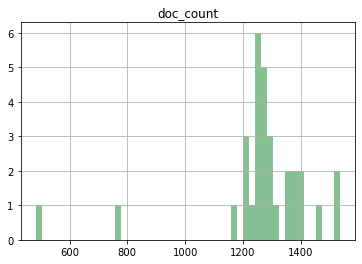

In [18]:
pd_table.hist(column='doc_count', color='#86bf91',bins=50)

In [19]:
# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel

In [20]:
output_notebook()  # Render inline in a Jupyter Notebook

Loading BokehJS ...

In [26]:
ds = ColumnDataSource(pd_table)
print(ds.data)
p = figure(width=800,height=400, x_axis_type='datetime')
p.line(source=ds, x='key_as_string', y='doc_count')
show(p)

{'index': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'key_as_string': array(['2019-07-23T16:58:30.000-05:00', '2019-07-23T16:59:00.000-05:00',
       '2019-07-23T16:59:30.000-05:00', '2019-07-23T17:00:00.000-05:00',
       '2019-07-23T17:00:30.000-05:00', '2019-07-23T17:01:00.000-05:00',
       '2019-07-23T17:01:30.000-05:00', '2019-07-23T17:02:00.000-05:00',
       '2019-07-23T17:02:30.000-05:00', '2019-07-23T17:03:00.000-05:00',
       '2019-07-23T17:03:30.000-05:00', '2019-07-23T17:04:00.000-05:00',
       '2019-07-23T17:04:30.000-05:00', '2019-07-23T17:05:00.000-05:00',
       '2019-07-23T17:05:30.000-05:00', '2019-07-23T17:06:00.000-05:00',
       '2019-07-23T17:06:30.000-05:00', '2019-07-23T17:07:00.000-05:00',
       '2019-07-23T17:07:30.000-05:00', '2019-07-23T17:08:00.000-05:00',
       '2019-07-23T17:08:30.000-05:00', '2019-07-23T17:09:00.000-05:00',
       '2019-07-23T17:09:30.00